In [ ]:
pip install livelossplot

In [ ]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
print(keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.4.3
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12904533969468495725
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8483016447326957240
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:

# Functions for later

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        self.params['metrics'].append('val_auc')
        self.params['metrics'].append('auc')
        self.params['metrics'].append('val_spec')
        self.params['metrics'].append('spec')
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        auc = roc_auc_score(self.y, y_pred)
        fpr, tpr, thresholds = roc_curve(self.y[:, 1], y_pred[:, 1])
        x = 0.95 # Sensitivity = 95%
        xp = tpr
        fp = fpr

        y = np.interp(x, xp, fp)
        specificity = 1-y

        y_pred_val = self.model.predict(self.x_val)
        auc_val = roc_auc_score(self.y_val[:,1], y_pred_val[:,1])
        fpr, tpr, thresholds = roc_curve(self.y_val[:, 1], y_pred_val[:, 1])
        x = 0.95
        xp = tpr
        fp = fpr
        y = np.interp(x, xp, fp)
        specificity_val = 1-y

        logs['auc'] = auc
        logs['val_auc'] = auc_val
        logs['spec'] = specificity
        logs['val_spec'] = specificity_val
        return()

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)




Mounted at /content/gdrive/


In [ ]:
train_path1 = 'gdrive/MyDrive/AyanScienceFair/ResizedTrainAll2/'
test_path1 = 'gdrive/MyDrive/AyanScienceFair/ResizedTestAll2/'

In [ ]:
# AMA Changes
from keras.applications.resnet50 import preprocess_input
#mygenerator = ImageDataGenerator(dtype='float32',
#                                     preprocessing_function=preprocess_input, featurewise_center=True, featurewise_std_normalization=True)
# Parameters learned from training images only; These will be applied to all images that are loaded
mygenerator = ImageDataGenerator(dtype='float32',
                                     preprocessing_function=preprocess_input, samplewise_center=True, samplewise_std_normalization=True)

mygenerator.mean = 16
mygenerator.std = 55.6

#mygenerator = ImageDataGenerator(dtype='float32',
                                     #preprocessing_function=preprocess_input, samplewise_center=True, samplewise_std_normalization=True)

#mygenerator = ImageDataGenerator(dtype='float32',
#                                     preprocessing_function=preprocess_input)


#datagen.fit(trainX)
# prepare an iterators to scale images
#train_iterator = datagen.flow(trainX, trainY, batch_size=64)
#test_iterator = datagen.flow(testX, testY, batch_size=64)

train_batch = mygenerator.flow_from_directory(train_path1, target_size=(224, 224), color_mode='rgb',  class_mode = 'categorical',batch_size=2500)
#train_batch = mygenerator.standardize(train_batch)

# calculate mean on training dataset
# mygenerator.fit(train_batch)



#test_batch =mygenerator.flow_from_directory(test_path1, target_size=(224, 224), color_mode='grayscale',  classes ='categorical', batch_size=411)
test_batch =mygenerator.flow_from_directory(test_path1, target_size=(224, 224), color_mode='rgb',  class_mode = 'categorical',batch_size=2500)

Found 2939 images belonging to 2 classes.
Found 830 images belonging to 2 classes.


In [ ]:
#Train_imgs.shape[0]

SET WHETHER DOING TRAINING OR TESTING

In [ ]:
trainFlag = False   # set to `True` for training; `False` for testing

In [ ]:
if trainFlag:
  import os.path
  if os.path.exists(train_path1+'Train_imgs4.npy'):
    Train_imgs = np.load(train_path1+'Train_imgs4.npy')
    Train_labels= np.load(train_path1+'Train_labels4.npy')
    Test_imgs, Test_labels = next(test_batch)
  else:
    Train_imgs, Train_labels = next(train_batch)
    Test_imgs, Test_labels = next(test_batch)  # do this down below when actual do testing operation
    Train_imgs.shape
    np.save(train_path1+'Train_imgs4.npy',Train_imgs)
    np.save(train_path1+'Train_labels4.npy',Train_labels)


In [ ]:
if trainFlag:
  # Make validation data
  PercSplit = 0.8

  Tlength = round(Train_imgs.shape[0]*PercSplit)

  XTrain = Train_imgs[:Tlength-1, :, :, :]
  #mean = (np.mean(XTrain[:, :, :, 0], dtype = XTrain.dtype),
  #         np.mean(XTrain[:, :, :, 1], dtype = XTrain.dtype),
  #         np.mean(XTrain[:, :, :, 2], dtype = XTrain.dtype))
  #XTrain = XTrain - mean
  YTrain = Train_labels[:Tlength-1, :]


  XVal = Train_imgs[Tlength:, :, :]
  YVal = Train_labels[Tlength:, :]


  XTest = Test_imgs
  YTest = Test_labels

  print(XTrain.shape)
  print(YTrain.shape)

  print(XVal.shape)
  print(YVal.shape)

print(XTest.shape)



(1999, 224, 224, 3)
(1999, 2)
(500, 224, 224, 3)
(500, 2)
(830, 224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, Input,Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#from livelossplot.inputs.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

import os
import numpy as np
import tensorflow as tf
import scipy
import random
from scipy import io

import matplotlib.pyplot as plt
import time

max =  7.0215273
min =  -3.0565147
mean =  -0.10284102


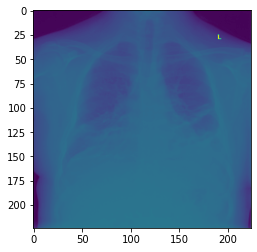

In [ ]:
if trainFlag:
  # Check images
  iNow = 125
  plt.imshow(XTrain[iNow,:,:,1]/255.)
  XTrain[iNow,20:34,1,1]
  print("max = ",np.max(XTrain[iNow,:,:,1]))
  print("min = ",np.min(XTrain[iNow,:,:,1]))
  print("mean = ",np.mean(XTrain[iNow,:,:,1]))
  YVal[iNow]

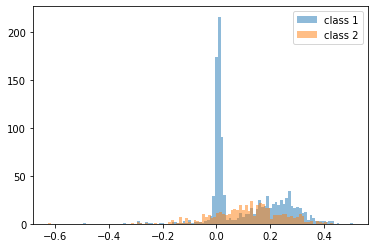

Prevalence Class 1:  0.6962822936357907
Train Images Mean: -6.2960694e-09  std: 1.0


In [ ]:
# Sanity check to see if medians different between two groups
if 1:
  med1 =[]
  med2 = []
  mnl=[]
  stdl=[]

  for iNow in range(1587):
    if(YTrain[iNow,0] == 0):
      med1.append(np.median(XTrain[iNow,:,:,:]))
    else:
      med2.append(np.median(XTrain[iNow,:,:,:]))
    mnl.append(np.mean(XTrain[iNow,:,:,:]))
    stdl.append(np.std(XTrain[iNow,:,:,:]))

  bins = 100
  plt.hist(med1, bins, alpha=0.5, label='class 1')
  plt.hist(med2, bins, alpha=0.5, label='class 2')
  plt.legend(loc='upper right')
  plt.show()
  print('Prevalence Class 1: ',len(med1)/(len(med1)+len(med2)))
  print('Train Images Mean:',np.mean(mnl), ' std:',np.mean(stdl))

# RESNET Architecture

In [ ]:
#Load the pre-trained model
image_size = 224
num_classes = 2
base_lr = 1e-4
min_lr = 1e-12
Reg = 0.05
Drop = 0

base_model = ResNet50(weights='imagenet', include_top=True)

#Add a fully connected layer with one output
x = Dropout(Drop)(base_model.layers[-2].output)
x = Dense(32, activation='sigmoid', kernel_regularizer=regularizers.l2(Reg))(x)
#x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(Reg))(x)
#x = Dropout(Drop)(x)
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(Reg))(x)
model = Model(inputs = base_model.input, outputs = predictions )
model.summary()

for layer in base_model.layers[:-1]:
    layer.trainable = True

adm = Adam(lr = base_lr)
# parallel_model = multi_gpu_model(model, gpus=4)
model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'], sample_weight_mode = None)
#from tensorflow.python.keras import optimizers


#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = 'accuracy')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# # Check the trainable status of the individual layers
for layer in model.layers:
     print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7faf24960f10> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7faf221d8390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7faf2219d610> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7faf22129a90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7faf24960bd0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7faf21095310> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7faf21095550> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7faf220cbc10> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7faf210a0550> True
<tensorflow.python.keras.layers.core.Activation object at 0x7faf2102d950> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7faf221297d0> True
<tensorflow.python.keras.layers.normaliz

In [ ]:
# Path to save model
#save_file = '/Users/anandnair/AyanScienceFair2021/FineTuneResNet_Findings'+'/RUN_Alessio'
save_file = 'gdrive/MyDrive/AyanScienceFair/Trial2Findings'
checkpoint_path = save_file
print(checkpoint_path)
os.makedirs(checkpoint_path, exist_ok=True)
weightsGood = checkpoint_path + '/weightsResNet50.h5'

gdrive/MyDrive/AyanScienceFair/Trial2Findings


In [ ]:

if trainFlag:
  early_stopping = EarlyStopping(monitor='val_loss', patience = 20)
  #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=min_lr, verbose = 1)
  #checkpointer = ModelCheckpoint(filepath = checkpoint_path + '/weights.h5' , verbose=1, monitor = 'val_loss', mode = 'min', save_best_only=True)

  #callback_list = [roc_callback(training_data=(XTrain, YTrain), validation_data=(XVal, YVal)), checkpointer, early_stopping]

  checkpoint = ModelCheckpoint(weightsGood, monitor='val_loss',
                              save_weights_only=True, mode='min', verbose=1)
  callbacks=[PlotLossesKeras(), checkpoint,early_stopping]

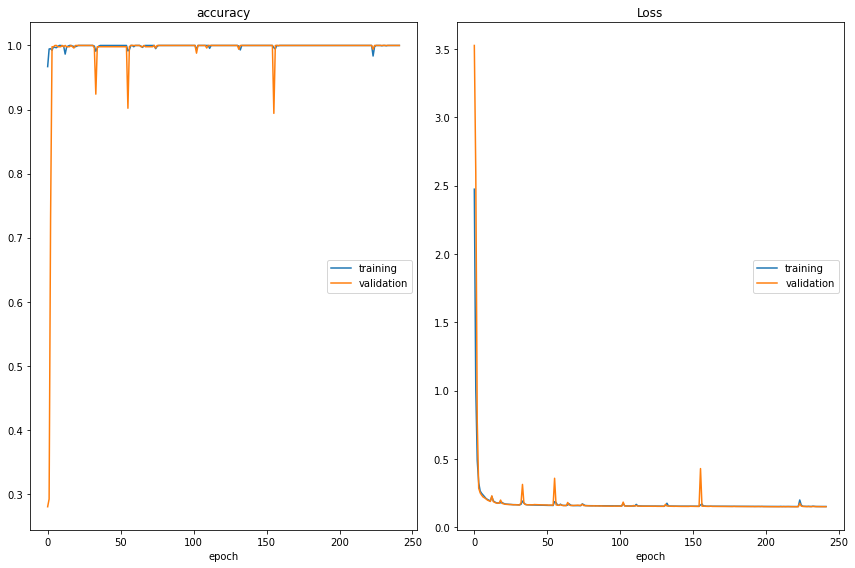

accuracy
	training         	 (min:    0.967, max:    1.000, cur:    1.000)
	validation       	 (min:    0.280, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.152, max:    2.474, cur:    0.153)
	validation       	 (min:    0.151, max:    3.525, cur:    0.151)

Epoch 00242: saving model to gdrive/MyDrive/AyanScienceFair/Trial2Findings/weightsResNet50.h5


In [ ]:
if trainFlag:
  batch_size = 10
  t = time.time()
  #history = model.fit(XTrain, YTrain, batch_size, epochs=5000, validation_data=(XVal, YVal),
  #                   shuffle = True)

  history = model.fit(XTrain, YTrain, batch_size, epochs=5000, validation_data=(XVal, YVal),
                      callbacks = callbacks, shuffle = True)
  elapsed = time.time() - t

In [ ]:
# Everything below if in testing phase (trainFlag=False)
if not trainFlag:
  model.load_weights(weightsGood)

  import os.path
  if os.path.exists(test_path1+'XTest2.npy'):
    XTest = np.load(test_path1+'XTest2.npy')
    YTest= np.load(test_path1+'YTest2.npy')
  else:
    XTest, YTest = next(test_batch)
    np.save(test_path1+'XTest2.npy',XTest)
    np.save(test_path1+'YTest2.npy',YTest)



# Could use "model" for doing prediction now


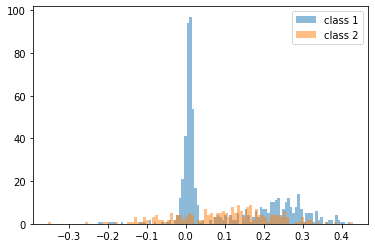

Prevalence Class 1:  0.7421686746987952
Test Images Mean: -6.9934454e-09  std: 1.0


In [ ]:
# Sanity check to see if medians different between two groups
if 1:
  med1 =[]
  med2 = []
  mnl=[]
  stdl=[]

  for iNow in range(np.shape(YTest)[0]):
    if(YTest[iNow,0] == 0):
      med1.append(np.median(XTest[iNow,:,:,:]))
    else:
      med2.append(np.median(XTest[iNow,:,:,:]))
    mnl.append(np.mean(XTest[iNow,:,:,:]))
    stdl.append(np.std(XTest[iNow,:,:,:]))

  bins = 100
  plt.hist(med1, bins, alpha=0.5, label='class 1')
  plt.hist(med2, bins, alpha=0.5, label='class 2')
  plt.legend(loc='upper right')
  plt.show()
  print('Prevalence Class 1: ',len(med1)/(len(med1)+len(med2)))
  print('Test Images Mean:',np.mean(mnl), ' std:',np.mean(stdl))

In [ ]:
np.shape(YTest)[0]

830

# Evaluate Performance

In [ ]:
#load model
#loaded_model = load_model(checkpoint_path + '/weights.h5')

#New model
#base_lr = 1e-9

#new_model = Model(inputs=loaded_model.input, outputs=loaded_model.output)
#base_lr = 1e-4
#adm = Adam(lr = base_lr)

#new_model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode = None)
#new_model.set_weights(loaded_model.get_weights())

In [ ]:
if not trainFlag:
  scores = model.predict(XTest)


Accuracy =  0.9963855421686747
AUC =  0.9999620706396408
Specificity at 95% Sensivity=  1.0
Confusion Matrix : 
 [[214   0]
 [  3 613]]
Accuracy :  0.9963855421686747
Sensitivity :  1.0
Specificity :  0.9951298701298701


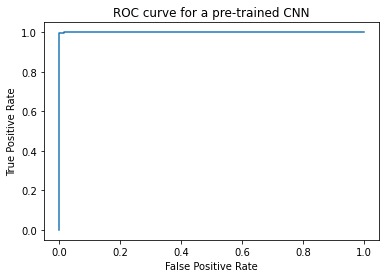

In [ ]:
if not trainFlag:
  # Performance on test set
  acc_val = sum(np.equal(np.argmax(scores, axis = 1), YTest[:, 1]))/YTest.shape[0]
  print('Accuracy = ', acc_val)

  auc_val = roc_auc_score(YTest[:,1], scores[:, 1])
  print('AUC = ', auc_val)

  fpr, tpr, thresholds = roc_curve(YTest[:, 1], scores[:, 1])
  x = 0.95
  xp = tpr
  fp = fpr
  y = np.interp(x, xp, fp)
  specificity_val = 1-y
  print('Specificity at 95% Sensivity= ', specificity_val)

  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for a pre-trained CNN')
  figout = save_file+'/ROC1.pdf'
  plt.savefig(figout)
  figout
  from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(scores, axis = 1)

cm1 = confusion_matrix(YTest[:,1],predicted_labels)

print('Confusion Matrix : \n', cm1)



total1=sum(sum(cm1))

#####from confusion matrix calculate accuracy

accuracy1=(cm1[0,0]+cm1[1,1])/total1

print ('Accuracy : ', accuracy1)



sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

print('Sensitivity : ', sensitivity1 )



specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print('Specificity : ', specificity1)


In [ ]:


print(scores)

[[0.00235141 0.99764854]
 [0.00235674 0.9976433 ]
 [0.00234148 0.9976585 ]
 ...
 [0.00237338 0.9976266 ]
 [0.0023786  0.99762136]
 [0.00234425 0.99765575]]


Accuracy =  0.994
AUC =  1.0
Specificity =  1.0
Specificity at 95% Sensivity=  1.0


'gdrive/MyDrive/AyanScienceFair/Trial2Findings/ROC1_onValication.pdf'

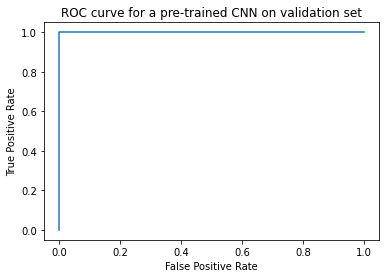

In [ ]:
#Performance on validation set as sanity check

scores = model.predict(XVal)

acc_val = sum(np.equal(np.argmax(scores, axis = 1), YVal[:, 1]))/YVal.shape[0]
print('Accuracy = ', acc_val)

auc_val = roc_auc_score(YVal[:,1], scores[:, 1])
print('AUC = ', auc_val)

fpr, tpr, thresholds = roc_curve(YVal[:, 1], scores[:, 1])
x = 0.95
xp = tpr
fp = fpr
y = np.interp(x, xp, fp)
specificity_val = 1-y
print('Specificity = ', specificity_val)
print('Specificity at 95% Sensivity= ', specificity_val)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for a pre-trained CNN on validation set')
figout = save_file+'/ROC1_onValication.pdf'
plt.savefig(figout)
figout

# Model, Light-weight mobile version


In [ ]:
trainMobileFlag = True
#***NOT THE REAL MODEL***

#create model
model_mobile = Sequential()#add model layers
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu', input_shape=(224,224,3)))

model_mobile.add(MaxPooling2D())
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())
#8 LAYERS
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())
#10 LAYERS
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())
#12 LAYERS
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())
#14 LAYERS
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())
#16 lAYERS
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(MaxPooling2D())



model_mobile.add(Flatten())
model_mobile.add(Dense(2, activation='softmax'))




model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobile.summary()

ValueError: ignored

### LIGHTWEIGHT MODEL ARCHITECTURE

In [ ]:
trainMobileFlag = True
## ALESSIO SUGGESTED MODS
#***REAL MODEL***

#create model
model_mobile = Sequential()#add model layers
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu', input_shape=(224,224,3)))
model_mobile.add(BatchNormalization())
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(BatchNormalization())
model_mobile.add(MaxPooling2D())
model_mobile.add(Conv2D(2, kernel_size=3, activation='relu'))
model_mobile.add(BatchNormalization())
model_mobile.add(MaxPooling2D())
model_mobile.add(Flatten())
model_mobile.add(Dense(2, activation='softmax'))




model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 2)       56        
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 2)       8         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 2)       38        
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 2)       8         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 2)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 2)       38        
_________________________________________________________________
batch_normalization_2 (Batch (None, 108, 108, 2)       8

In [ ]:
save_file = 'gdrive/MyDrive/AyanScienceFair/Trial2Findings'
checkpoint_path = save_file
print(checkpoint_path)
import os
os.makedirs(checkpoint_path, exist_ok=True)
weightsMobile = checkpoint_path + '/weights_LNN.h5'

gdrive/MyDrive/AyanScienceFair/Trial2Findings


In [ ]:
if trainMobileFlag:
  early_stopping = EarlyStopping(monitor='val_loss', patience = 20)
  checkpoint = ModelCheckpoint(weightsMobile, monitor='val_loss',
                              save_weights_only=True, mode='min', verbose=1)
  callbacks=[PlotLossesKeras(), checkpoint,early_stopping]

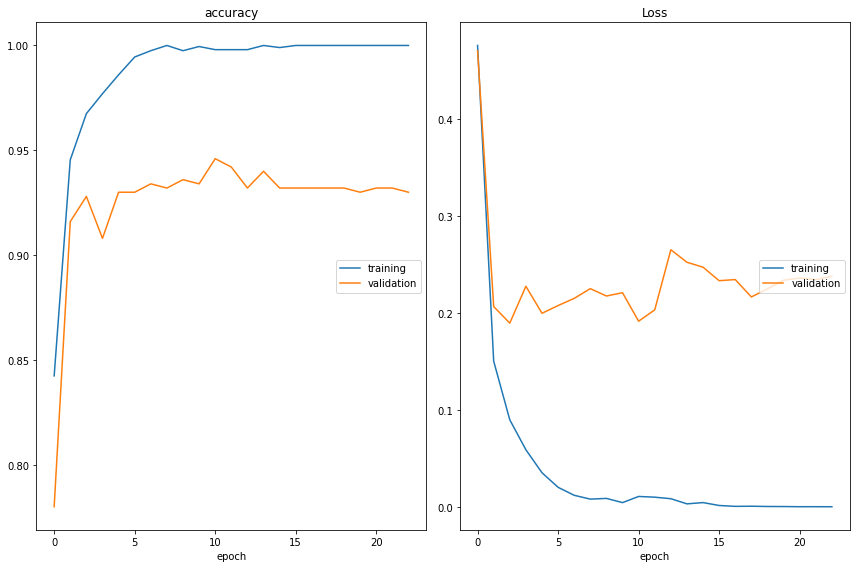

accuracy
	training         	 (min:    0.842, max:    1.000, cur:    1.000)
	validation       	 (min:    0.780, max:    0.946, cur:    0.930)
Loss
	training         	 (min:    0.001, max:    0.476, cur:    0.001)
	validation       	 (min:    0.190, max:    0.470, cur:    0.238)

Epoch 00023: saving model to gdrive/MyDrive/AyanScienceFair/Trial2Findings/weights_LNN.h5


In [ ]:
if trainMobileFlag:
  batch_size = 20
  t = time.time()

  history = model_mobile.fit(XTrain, YTrain, batch_size, epochs=5000, validation_data=(XVal, YVal),
                      callbacks = callbacks, shuffle = True)
  elapsed = time.time() - t

# Evaluate Performance of Mobile, Lightweight Version

In [ ]:
trainMobileFlag = False
if not trainMobileFlag:
  model_mobile.load_weights(weightsMobile)

  import os.path
  if os.path.exists(test_path1+'XTest3.npy'):
    XTest = np.load(test_path1+'XTest3.npy')
    YTest= np.load(test_path1+'YTest3.npy')
  else:
    XTest, YTest = next(test_batch)
    np.save(test_path1+'XTest3.npy',XTest)
    np.save(test_path1+'YTest3.npy',YTest)

  scores = model_mobile.predict(XTest)

Accuracy =  0.9168674698795181
AUC =  0.9583801128777764
Specificity at 95% Sensivity=  0.8177570093457944
Confusion Matrix : 
 [[175  39]
 [ 30 586]]
Accuracy :  0.9168674698795181
Sensitivity :  0.8177570093457944
Specificity :  0.9512987012987013


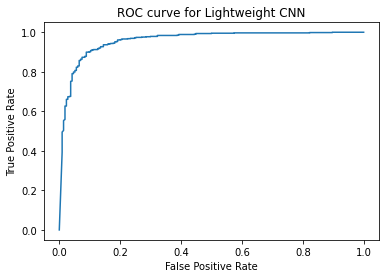

In [ ]:
if not trainMobileFlag:
  # Performance on test set
  acc_val = sum(np.equal(np.argmax(scores, axis = 1), YTest[:, 1]))/YTest.shape[0]
  print('Accuracy = ', acc_val)

  auc_val = roc_auc_score(YTest[:,1], scores[:, 1])
  print('AUC = ', auc_val)

  fpr, tpr, thresholds = roc_curve(YTest[:, 1], scores[:, 1])
  x = 0.95
  xp = tpr
  fp = fpr
  y = np.interp(x, xp, fp)
  specificity_val = 1-y
  print('Specificity at 95% Sensivity= ', specificity_val)

  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for Lightweight CNN')
  figout = save_file+'/ROC1_lightweight.pdf'
  plt.savefig(figout)
  figout
from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(scores, axis =
1)

cm1 = confusion_matrix(YTest[:,1],predicted_labels)

print('Confusion Matrix : \n', cm1)



total1=sum(sum(cm1))

#####from confusion matrix calculate accuracy

accuracy1=(cm1[0,0]+cm1[1,1])/total1

print ('Accuracy : ', accuracy1)



sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

print('Sensitivity : ', sensitivity1 )



specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print('Specificity : ', specificity1)


# History of training -- BELOW IS OLD

In [ ]:
#***IGNORE THESE BLOCKS OF CODE***

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    auc_list = [s for s in history.history.keys() if 'auc' in s and 'val' not in s]
    val_auc_list = [s for s in history.history.keys() if 'auc' in s and 'val' in s]
    spec_list = [s for s in history.history.keys() if 'spec' in s and 'val' not in s]
    val_spec_list = [s for s in history.history.keys() if 'spec' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, np.log10(history.history[l]), 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, np.log10(history.history[l]), 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    ## AUC
    plt.figure(3)
    for l in auc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training AUC (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_auc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation AUC (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    ## Spec at 95% sensitivity
    plt.figure(3)
    for l in spec_list:
        plt.plot(epochs, history.history[l], 'b', label='Training Specificity (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_spec_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation Specificity (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Specificity at 95% sensitivity')
    plt.xlabel('Epochs')
    plt.ylabel('Specificity at 95% sensitivity')
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)